# Machine Learning Demonstrations

In this notebook, we showcase how to use the kdb+/q clustering library, contained within the ML-Toolkit, and to plot outputs using embedPy. Below we demonstrate how to use each algorithm contained within the toolkit and how to use the library in conjunction with real-world data.

<div class="alert alert-danger">
To run the below notebook, ensure that dependencies specified in <b>requirements.txt</b> have been correctly installed.
</div>

# Clustering

Clustering is a technique used in both data mining and machine learning to group similar data points together in order to identify patterns in their distributions.

The task of clustering data can be carried out using a number of algorithms. The algorithms defined in the toolkit work based on distinct clustering methodologies namely; connectivity-based, centroid-based or density-based models. Each type of algorithm defines clusters based on:

-   **Centroid-based** - distances from single points which represent the cluster.
-   **Density-based** - clusters being within a certain distance of each other and in defined concentrations.
-   **Connectivity-based** - distances between individual data points.

Each algorithm works by iteratively joining, separating or reassigning points until the desired number of clusters have been achieved.

The process of finding the correct cluster for each data point is a case of trial and error, where parameters must be altered in order to find the optimum solution.

## Machine Learning Toolkit

The ML-Toolkit contains general use utilities, an implementation of the FRESH (Feature Extraction based on Scalable Hypothesis tests) algorithm, cross validation functions and clustering algorithms. The primary purpose of these libraries are to provide kdb+/q users with access to commonly-used ML functions for preprocessing data, extracting features and scoring results.

The toolkit is used throughout this notebook and can be loaded using the below syntax.

In [1]:
\l ml/ml.q
.ml.loadfile`:clust/init.q

## Sections

This notebook is split into 2 distinct sections, which cover the different algorithms contained in the toolkit, along with a real-world example.

[**Algorithms**](#Algorithms):
1. Centroid-based: [K-Means](#K-Means)
2. Density-based: [DBSCAN](#DBSCAN), [Affinity Propagation](#Affinity-Propagation)
3. Connectivity-based: [Hierarchical](#Hierarchical), [CURE](#CURE)

**Real-World Example**:
4. [Chocolate Bar Ratings](#Chocolate-Bar-Ratings)

---

## Load scripts and import functions

Throughout this notebook, we cluster data from the `sklearn` and `pyclustering` sample libraries and then visualize the results using `matplotlib`.

Each of the libraries are imported using embedPy, as shown below.

In [2]:
// import matplotlib from Python
plt:.p.import`matplotlib.pyplot

// sklearn samples
skldata:.p.import`sklearn.datasets
blobs:skldata[`:make_blobs;<]
moons:skldata[`:make_moons;<]
iris :skldata[`:load_iris;<]

// pyclustering samples
pcldata:.p.import`pyclustering.samples.definitions
pclutil:.p.import`pyclustering.utils
fcps_samp:pcldata`:FCPS_SAMPLES
smpl_samp:pcldata`:SIMPLE_SAMPLES
read_samp:pclutil`:read_sample

---

<a id='Affinity-Propagation'></a>
# Algorithms

In this section we showcase how to use the algorithms contained within the ML-Toolkit. We start with descriptions of centroid- and density-based clustering algorithms, followed by connectivity-based algorithms.

Before continuing through the notebook, it is worth noting that for simplicity the algorithms below have been applied to 2D datasets with 1000 points in each. All algorithms can be applied in higher dimensional examples.

---

<a id='K-Means'></a>
# K-Means

Clustering data with the k-means algorithm begins with the selection of *k* data points as cluster centres. Data points are then assigned to the nearest cluster centres.

The algorithm follows an iterative refinement process which will run *n* times, updating the cluster centres and assigned points during each iteration.

Advantages of k-means include:
- The simplicity of the algorithm, both to implement and run, makes it extremely efficient and easy to understand
- Creating centroids is an easy way to perform data reduction

### Inputs

To apply k-means to q data, the function `.ml.clust.kmeans` must be called using the following arguments:
- `d` - data in long matrix (`value flip` form)
- `df` - distance function, must be euclidean - ```edist`e2dist```
- `k` - number of clusters
- `n` - number of iterations
- `i` - boolean indicating initialisaton type: both select k points from the dataset as cluster centres, `1b` initialises the [k-means++](https://en.wikipedia.org/wiki/K-means%2B%2B) algorithm, `0b` selects *k* random points

### Example

In this example, we show how k-means can be used to identify clusters in datasets with no apparent structure.

The algorithm is able to cluster the data into evenly spaced clusters in comparison to other denisty or distance based algorithms.

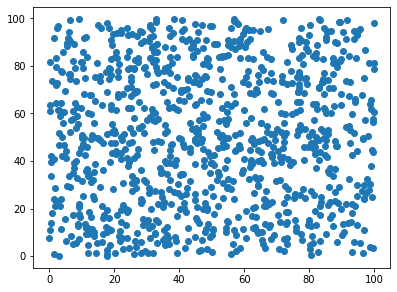

In [3]:
\S 20
d1:2 1000#4000?100.
plt[`:scatter]. d1;
plt[`:show][];

In this case, we want to identify `3` clusters across `10` iterations of the algorithm using euclidean squared distances. Note that in this case, k-means will be initialized using kmeans++.

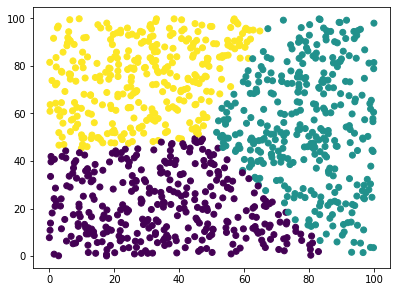

Time taken for K-Means: 00:00:00.002


In [4]:
start:.z.t
r1:.ml.clust.kmeans[d1;`e2dist;3;10;1b]
end:string .z.t-start;
plt[`:scatter][;;`c pykw r1]. d1;
plt[`:show][];
-1"Time taken for K-Means: ",end;

---

<a id='DBSCAN'></a>
## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

The DBSCAN algorithm groups points together that are closely packed in areas of high-density. Any points in low-density regions are seen as outliers.

DBSCAN does not require the user to pass in the number of clusters, it will determine the optimum number for you. This decision is based on a minimum number of points per cluster and an epsilon radius which describes the neighbourhood of each point, which must both be passed in as inputs.

Advantages of DBSCAN include:
- The number of clusters does not need to be known prior to use
- The algorithm is extremely useful for anomaly detection, and will return outliers as a separate cluster

### Inputs

DBSCAN is called using the function `.ml.clust.dbscan` which takes the followning arguments:
- `d` - data in long matrix (`value flip` form)
- `df`- distance function, e.g. ```edist`e2dist`mdist```
- `p` - minimum number of points in neighbourhood
- `e` - epsilon radius

### Example

Below shows how DBSCAN can be used to cluster data in odd shapes, such a crescent moons.

Distance-based models would struggle to correctly classify datasets like the one below as clusters are in close proximity and so points could easily be included in the wrong cluster.

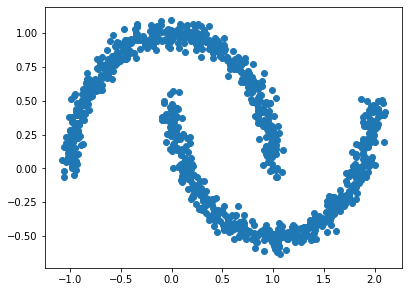

In [5]:
d2:flip moons[`n_samples pykw 1000;`noise pykw 0.05]0
plt[`:scatter]. d2;
plt[`:show][];

Density based models like DBSCAN are able to distinguish between the clusters given that points in each are densely packed.

Euclidean squared distances have been used for this example, with a minimum of `5` points required per cluster and a neighbourhood radius of `0.04`.

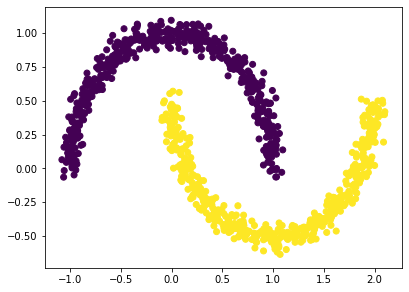

Time taken for DBSCAN: 00:00:00.020


In [6]:
start:.z.t
r2:.ml.clust.dbscan[d2;`e2dist;5;.04]
end:string .z.t-start;
plt[`:scatter][;;`c pykw r2]. d2;
plt[`:show][];
-1"Time taken for DBSCAN: ",end;

---

<a id='Affinity-Propagation'></a>
## Affinity Propagation

The affinity propagation works by grouping data based on the similarity between points. It then finds *k* exemplars which best represent the points in each cluster.

Similarly to DBSCAN, the algorithm does not require the user to input the number of clusters and will determine the optimum solution by exchanging real-valued messages between points until a high-valued set of exemplars are produced.

A damping coefficient is used to reduce the availability and responsibility of messages passed between points, while the preference value is used to set the diagonal values of the similarity matrix.

Advantages of affinity propagration include:
- The number of clusters does not need to be known prior to use
- The algorithm is highly scalable and can be applied to large similarity matrices

### Inputs

Affinity propagation can be applied to data using `.ml.clust.ap` which takes the followning arguments:
- `d` - data in long matrix (value flip form)
- `df` - distance function, e.g. ````edist`e2dist`nege2dist`mdist````
- `dmp` - damping coefficient, where $0\le dmp \le 1$
- `p` - preference function, e.g. ``` `min`max`med ``` etc.

### Example

In the example below we create clusters using the `sklearn` samples library. There are 1000 points contained in the dataset and the random seed has been set so that results can be replicated.

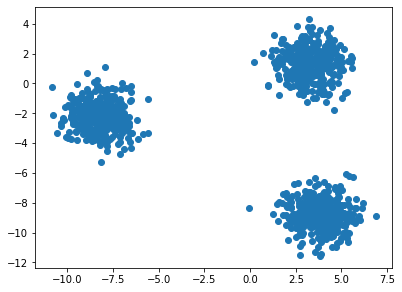

In [7]:
d3:flip blobs[`n_samples pykw 1000;`random_state pykw 500]0
plt[`:scatter]. d3;
plt[`:show][];

Below we apply a clustering algorithm, we can use the elbow method to decide how many clusters to group the data into.

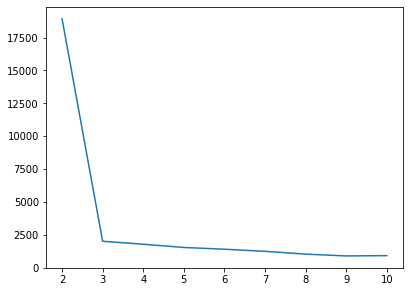

In [8]:
plt[`:plot][2+til 9;.ml.clust.elbow[d3;`e2dist;10]];
plt[`:show][];

We can see that, as expected, the elbow method suggests that the data should be grouped into 3 clusters.

Below we demonstrate using `.ml.clust.ap` to cluster the above dataset. In the example, `0.8` is passed as the damping coefficient, while `min` is used to calculate the diagonal of the similarity matrix.

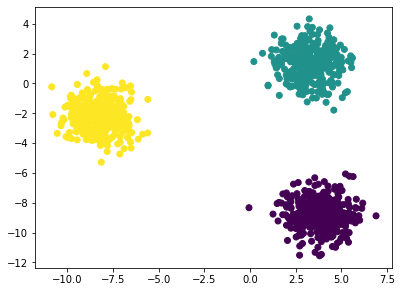

Time taken for Affinity Propagation: 00:00:01.393


In [9]:
start:.z.t
r3:.ml.clust.ap[d3;`nege2dist;.8;min]
end:string .z.t-start;
plt[`:scatter][;;`c pykw r3]. d3;
plt[`:show][];
-1"Time taken for Affinity Propagation: ",end;

We can then demostrate how well the clusters have been selected by using the Davies Bouldin index, where the index has a minimum score of 0, with lower values indicating better clustering.

In [10]:
.ml.clust.daviesbouldin[d3;r3]

0.2374849


---

<a id='Hierarchical'></a>
## Hierarchical Clustering

As the name suggests, hierarchical clustering algorithms create hierarchies of clusters. The implementation described here follows an agglomerative approach, where each data point is initially treated as its own cluster.

There are 5 possible linkages in hierarchical clustering:
- Single
- Complete
- Average
- Centroid
- Ward

Euclidean, Euclidean squared or Manhattan distances can be used with each linkage, except for ward which only works with Euclidean squared distances.

Similarly to CURE, the q and C k-d trees can be used for the single and centroid implementations.

At each step, the two closest clusters (defined by the linkage) are merged until only one cluster remains, which contains all of the data points. Results can be represented by a dendrogram, used to suggest the “appropriate” number of clusters in the data. 

Advantages of hierarchical clustering include:
- The algorithms can be used to produce a dendrogram structure, which is extremely informative compared to other algorithms.
- The different methods available within hierarchical clustering make it applicable to a wide range of datasets.

### Inputs

To run a hierarchical algorithm, `.ml.clust.hc` is called which takes the following arguments:
- `d` - data in `value flip` matrix form
- `df`- distance function, e.g. ``` `e2dist`edist`mdist ```
- `lf`- linkage function, e.g. ```single`complete`average`centroid`ward ```
- `k` - number of clusters

### Example

For simplicity, we only showcase some of the hierarchical linkages below.

The first example uses ward linkage with euclidean squared distances. Blobs are generated as before, using the `sklearn` samples library. `200` datapoints are used and a random state is again chosen.

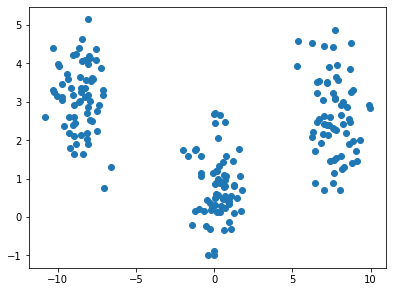

In [11]:
d4:flip blobs[`n_samples pykw 200;`random_state pykw 394]0
plt[`:scatter]. d4;
plt[`:show][];

In the first case, we demostrate how to use ward linkage in conjunction with euclidean squared distances to find 3 clusters in the data.

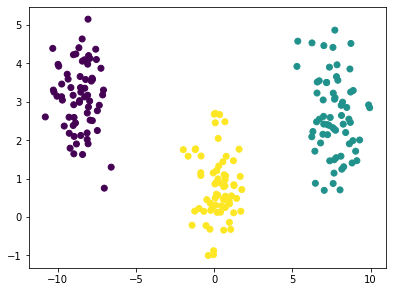

Time taken for Ward Linkage Hierarchical: 00:00:00.146


In [12]:
start:.z.t
r4w:.ml.clust.hc[d4;`e2dist;`ward;3]
end:string .z.t-start;
plt[`:scatter][;;`c pykw r4w]. d4;
plt[`:show][];
-1"Time taken for Ward Linkage Hierarchical: ",end;

In the second case, complete linkage is used in conjunction with manhattan distances.

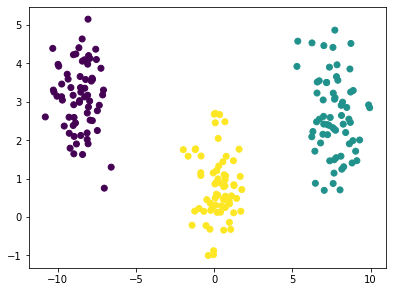

Time taken for Complete Linkage Hierarchical: 00:00:00.161


In [13]:
start:.z.t
r4c:.ml.clust.hc[d4;`mdist;`complete;3]
end:string .z.t-start;
plt[`:scatter][;;`c pykw r4c]. d4;
plt[`:show][];
-1"Time taken for Complete Linkage Hierarchical: ",end;

We can then check how well the data has been clustered in both methods, with regards to their respective distance metrics, using the Silhouette coefficient.

In [14]:
// Ward linkage
.ml.clust.silhouette[d4;`e2dist;r4w;1b]

// Complete linkage
.ml.clust.silhouette[d4;`mdist;r4c;1b]

0.9475706


0.7869327


---

<a id='CURE'></a>
## CURE (Clustering Using REpresentatives)

CURE clustering is a distance-based technique used to deal with datasets containing outliers and clusters of varying sizes and shapes.

Each cluster is represented by a specified number of representative points, chosen by taking the the most scattered points in each cluster and compressing them towards the cluster centre by a fixed amount.

In the implementation below, both q and C implementations of a k-dimensional (k-d) tree are available to store the representative points of each cluster (more information [here](https://code.kx.com/v2/ml/toolkit/clustering/kdtree)).

Advantages of CURE include:
- The use of a k-dimensional tree make the algorithm extremely efficient and highly scalable.
- The use of compression allows CURE to perform well in cases where the dataset provided contains outliers or has clusters of varying sizes and shapes.

### Inputs

In the cell below we demonstrate how to cluster data using the CURE algorithm. `.ml.clust.cure` is called with the following arguments:
- `data` is the data points in a horizontal matrix format
- `df` is the distance function as a symbol: ``` `e2dist`edist`mdist ```
- `k` is the number of clusters
- `n` is the number of representative points
- `c` is the compression

### Example

The below code creates a dataset of points belonging to 4 distinct clusters, 3 of which share the same centre. Most clustering algorithms do not perform well when presented with data in concentric circles. 

Note that the process has been random seeded so that results can be replicated.

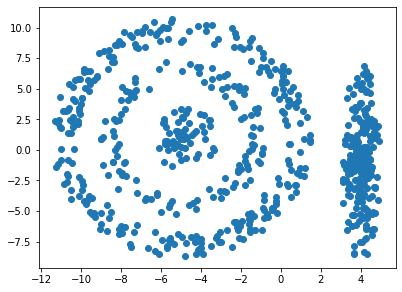

In [15]:
\S 20
dsc:{[n;r;s](r+n?s-r)*/:(cos;sin)@\:4*n?acos 0}
d5 :flip(-5 1)+(1 1.5)*dsc[1000; 0;1.8],'dsc[2000;3.1;4.2],'dsc[4000;5.2;6.5]
d5,:flip(4 -1)+(1 8)*dsc[4000; 0;1.]
d5@:neg[700&count d5]?count d5
plt[`:scatter]. d5:flip d5;
plt[`:show][];

By using representative points, CURE is able to perform well when applied to these kinds of datasets.

The below applies CURE to the dataset, using Euclidean squared distances, selecting `4` clusters, using `50` representative points and 0 compression. Results are then plotted using `matplotlib`.

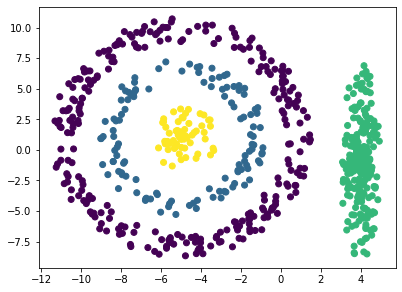

Time taken for CURE: 00:00:00.297


In [16]:
start:.z.t
r5:.ml.clust.cure[d5;`e2dist;4;50;0]
end:string .z.t-start;
plt[`:scatter][;;`c pykw r5]. d5;
plt[`:show][];
-1"Time taken for CURE: ",end;

---

# Real-World Example

<a id='Chocolate-Bar-Ratings'></a>
## Chocolate Bar Ratings

In the example below, we look at the kaggle [Chocolate Bar Ratings dataset](https://www.kaggle.com/rtatman/chocolate-bar-ratings), compiled by Brady Brelinski, the founder of the Manhattan Chocolate Society.

The dataset contains around 1,800 expert ratings for individual chocolate bars collected between 2006-2017. There is a focus on plain dark chocolate, with information on the origin and cocoa content of each bar produced. We will look specifically at the features for **cocoa percentage**, **rating** and **review date** of each chocolate bar.

Each bar is rated using the below scale, from worst to best:
1. **Unpleasant** - mostly unpalatable
2. **Disappointing** - passable, but contains at least 1 significant flaw
3. **Satisfactory** to 3.75. **Praiseworthy** - well made, with special qualities
4. **Premium** - superior flavor development, character and style
5. **Elite** - transcending beyond the ordinary limits

Where ratings are based on 4 main factors: *flavor, texture, aftermelt* and *overall opinion*, with flavor being the most important.

The aim in this example is to detect any outliers contained in the dataset using the clustering library contained in the ML-Toolkit. Additonal utility functions have also been defined below.

In [17]:
\l automl/automl.q
.automl.loadfile`:init.q

Requirements for deep learning models not available, these will not be run


In [18]:
/ utils

\d .ml
mode:{$[98h~t:type x;i.mode_calc each flip x;99h~t;i.mode_calc each x;i.mode_calc x]}
i.mode_calc:{n?max n:count each group x}
describe_mode:{key[d]!update mode:value .ml.mode x from value d:.automl.prep.i.describe x}

### Load data

In the below cell, we load in the chocolate dataset and return the shape of the features of interest, namely `cocoa_pcnt`, `rating`, `review_dt`.

<div class="alert alert-danger">
The data loaded in below has been preprocessed prior to use in this notebook to remove punctuation characters, convert null `bean_typ characters to <i>"Unknown"</i> and change column names to those more appropriate for q.
</div>

In [19]:
-1"Full dataset:\n";
show 5#cocoa:("SSISSSIFF";(),",")0:`:../data/cocoa.csv

-1"\nRelevant columns:\n";
show 5#d:select cocoa_pcnt,rating,review_dt from cocoa

-1"\nRelevant column info:\n";
show .ml.describe_mode d

Full dataset:

company company_loc ref  bean_origin broad_bean_origin bean_typ review_dt coc..
-----------------------------------------------------------------------------..
AMorin  France      1876 AguaGrande  SaoTome           Unknown  2016      0.6..
AMorin  France      1676 Kpime       Togo              Unknown  2015      0.7..
AMorin  France      1676 Atsane      Togo              Unknown  2015      0.7..
AMorin  France      1680 Akata       Togo              Unknown  2015      0.7..
AMorin  France      1704 Quilla      Peru              Unknown  2015      0.7..

Relevant columns:

cocoa_pcnt rating review_dt
---------------------------
0.63       3.75   2016     
0.7        2.75   2015     
0.7        3      2015     
0.7        3.5    2015     
0.7        3.5    2015     

Relevant column info:

          | count unique mean      std        min   max   type    mode 
----------| -----------------------------------------------------------
cocoa_pcnt| 1795  45     0.7169833 0.0632

We can see that the majority of reviews were carried out in 2015, with most bars receiving a pretty averge score of 3.5. The focus on dark chocolate is also apparent given that most bars selected contain around 70% cocoa mass.

### Prepare data

Given that the three features of interest vary in scales, it is important to standardize the data before passing it to a clustering algorithm. Below we apply the standard scaler function contained within the ML-Toolkit.

In [20]:
5#s:.ml.stdscaler d

cocoa_pcnt rating     review_dt
-------------------------------
-1.376022  1.180231   1.255692 
-0.2686652 -0.9121291 0.913975 
-0.2686652 -0.3890391 0.913975 
-0.2686652 0.6571409  0.913975 
-0.2686652 0.6571409  0.913975 


At this stage it is useful to visualize the data to see if any outliers are apparent.

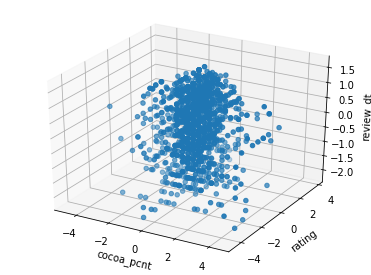

In [21]:
fig:plt[`:figure][];
.p.import[`mpl_toolkits.mplot3d]`:Axes3D;
ax:fig[`:add_subplot][111;`projection pykw"3d"];
ax[`:scatter]. data:value flip s;
ax[`:set_xlabel](sc:cols s)0;
ax[`:set_ylabel]sc 1;
ax[`:set_zlabel]sc 2;
plt[`:show][];

The plot makes clear that most data is clumped together in one obvious cluster, with a couple of sparse outliers present.

### Cluster data

It is now possible to apply clustering methods to the data. We have chosen to use the DBSCAN algorithm, contained within the ML-Toolkit, as this algorithm is commonly used in anomaly detection.

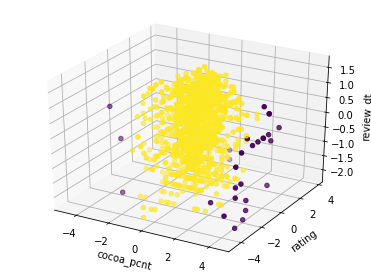


Time taken for DBSCAN: 00:00:00.085

Outliers:

cocoa_pcnt rating review_dt
---------------------------
0.7        5      2007     
0.7        5      2006     
1          1.75   2010     
1          1.5    2006     
1          1.5    2009     

Outliers info:

          | count unique mean      std       min   max   type    mode 
----------| ----------------------------------------------------------
cocoa_pcnt| 28    7      0.9178571 0.1772497 0.42  1f    numeric 1f   
rating    | 28    11     2.473214  0.9630663 1f    5f    numeric 1.5  
review_dt | 28    10     2010.607  3.166249  2006i 2016i numeric 2013i


In [22]:
/ cluster data
start:.z.t
rexample:.ml.clust.dbscan[data;`e2dist;10;2]
end:string .z.t-start

/ plot clusters
fig:plt[`:figure][];
ax:fig[`:add_subplot][111;`projection pykw"3d"];
ax[`:scatter][;;;`c pykw rexample]. data;
ax[`:set_xlabel]sc 0;
ax[`:set_ylabel]sc 1;
ax[`:set_zlabel]sc 2;
plt[`:show][];

-1"\nTime taken for DBSCAN: ",end;
-1"\nOutliers:\n";
show 5#outliers:d idx:where null rexample
-1"\nOutliers info:\n";
show .ml.describe_mode outliers

The algorithm has detected 31 outliers within the dataset. These have been grouped together into cluster `-1`.

Below we plot the distribution of each feature in the 31 outliers to see if any clear trends exist within the data.

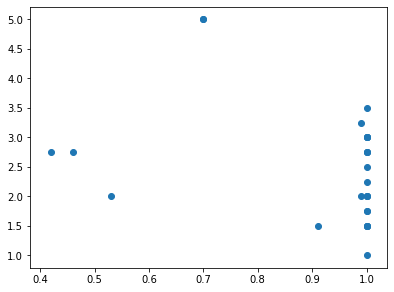

In [23]:
plt[`:scatter][outliers`cocoa_pcnt;outliers`rating];
plt[`:show][];

The majority of outliers were reviewed in 2013, with pretty low ratings, ranging mainly from 1-3. The most prominent feature of the plots is the number of bars present with 100% cocoa content.

We can check this against the number of 100% bars in the entire dataset:

In [24]:
exec count i from cocoa where cocoa_pcnt=1

20


All of the bars with 100% dark chocolate contained in the dataset appear in our outliers.

We can look specifically at the ratings and review date for those values:

In [25]:
\c 25 100
`rating xasc select from outliers where cocoa_pcnt=1

cocoa_pcnt rating review_dt
---------------------------
1          1      2008     
1          1.5    2006     
1          1.5    2009     
1          1.5    2012     
1          1.5    2010     
1          1.75   2010     
1          1.75   2013     
1          2      2014     
1          2      2008     
1          2      2007     
1          2.25   2013     
1          2.5    2013     
1          2.75   2013     
1          2.75   2013     
1          2.75   2016     
1          3      2013     
1          3      2008     
1          3      2015     
1          3      2015     
1          3.5    2013     


It looks as though the bars with higher cocoa percentage actually produce lower than average ratings as a whole compared to the other bars in the dataset.

---